In [390]:
# temp_rf.py
# Avery Krieger, adapted components from Tim Currier

# argumenmts: [1] date (yyyy-mm-dd); [2] series_number; [3] roi_set_name
# implementation: save_strfs.py 2022-03-17 1 roi_set_postfrom visanalysis.analysis import imaging_data, shared_analysis
from visanalysis.util import plot_tools
from visanalysis.analysis import imaging_data, shared_analysis
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for the legend patches
import numpy as np
import os
from two_photon_analysis import medulla_analysis as ma
import sys
import cv2
import warnings
from tifffile import imsave
from pathlib import Path 
from scipy.ndimage import gaussian_filter
from scipy.stats import sem

In [399]:
# define recording series to analyze
experiment_file_directory = '/Volumes/ROG2TBAK/data/bruker/20221027'
experiment_file_name = '2022-10-27' #sys.argv[1]
series_number = '5' #int(sys.argv[2])
roi_set_name = 'proximal_roi2' #sys.argv[3]

# join path to proper format for ImagingDataObject()
file_path = os.path.join(experiment_file_directory, experiment_file_name + '.hdf5')
print(file_path)

# create save directory
save_directory = '/Volumes/ROG2TBAK/data/bruker/trfs/' + experiment_file_name + '/'
print(save_directory)
Path(save_directory).mkdir(exist_ok=True)

# create ImagingDataObject (wants a path to an hdf5 file and a series number from that file)
ID = imaging_data.ImagingDataObject(file_path,
                                    series_number,
                                    quiet=True)

# get ROI timecourses and stimulus parameters
roi_data = ID.getRoiResponses(roi_set_name)
epoch_parameters = ID.getEpochParameters()
run_parameters = ID.getRunParameters()

/Volumes/ROG2TBAK/data/bruker/20221027/2022-10-27.hdf5
/Volumes/ROG2TBAK/data/bruker/trfs/2022-10-27/


# Recreate visual stimuli from stored seeds

In [400]:
# pull run parameters (same across all trials)
update_rate = run_parameters['update_rate']
#rand_min = run_parameters['rand_min']
#rand_max = run_parameters['rand_max']
rand_min = 0
rand_max = 1

# calculate size of noise grid, in units of patches (H,W)
#output_shape = (int(np.floor(run_parameters['grid_height']/run_parameters['patch_size'])), int(np.floor(run_parameters['grid_width']/run_parameters['patch_size'])));

# calculate number of time points needed
n_frames = update_rate*(run_parameters['stim_time']);

# initialize array that will contain stimuli for all trials
all_stims = np.zeros((int(n_frames),int(run_parameters['num_epochs'])))
# populate all-trial stimulus array
for trial_num in range(1, int(run_parameters['num_epochs']+1)):
    # pull start_seed for trial
    start_seed = epoch_parameters[(trial_num-1)]['start_seed']
    # initialize stimulus frames variable with full idle color
    stim = np.full(int(n_frames),run_parameters['idle_color'])
    # populate stim array (T) specifically during "stim time"
    for stim_ind in range(0, stim.shape[0]):
        # find time in sec at stim_ind
        t = stim_ind/update_rate;
        # define seed at each timepoint
        seed = int(round(start_seed + t*update_rate))
        np.random.seed(seed)
        # find random values for the current seed and write to pre-initialized stim array
        rand_values = np.random.choice([rand_min, (rand_min + rand_max)/2, rand_max], 1);
        stim[stim_ind]= rand_values
            
    # save trial stimulus to all_stims(Height, Width, Time, Trial)
    all_stims[:,(trial_num-1)] = stim;
    
all_stims.shape
# This is currently alternating NO OPTO and OPTO conditions 

(400, 150)

# Calculate TRF

In [408]:
# define filter length in seconds, convert to samples
filter_length = 6;
filter_len = filter_length*run_parameters['update_rate'];

# Initialize roi_trfs - ROI x Filter x Trials
roi_trfs = np.zeros((roi_data['epoch_response'].shape[0],int(filter_len),int(run_parameters['num_epochs'])))
# iterate over ROIs to save STRFs and movies
print('Calculating TRFs...')
for roi_id in range(0, roi_data['epoch_response'].shape[0]):
    # initialize strf by trial array (H,W,T,Tr)
    roi_trf = np.zeros((int(filter_len), int(run_parameters['num_epochs'])))
    for trial_num in range(0, int(run_parameters['num_epochs'])):
        current_resp = roi_data['epoch_response'][roi_id,trial_num]
        # initialize strf and full time series for update rate of stimulus
        full_t = np.arange(run_parameters['pre_time'],run_parameters['stim_time'] + run_parameters['pre_time'],1 / run_parameters['update_rate'])
        trf = np.zeros(int(filter_len))
        # linearly interpolate response to match stimulus timing
        full_resp = np.interp(full_t,roi_data['time_vector'],current_resp)
        resp_mean = np.mean(full_resp)
        resp_var = np.var(full_resp)
        # compute TRF for mean-subtracted stimulus and response; then compile STRF across patches
        n=all_stims.shape[1];
        ext_size=2*n-1
        fsize=2**np.ceil(np.log2(ext_size)).astype('int')
        vis_stim = all_stims[:, trial_num]
        vis_mean = np.mean(vis_stim)
        filter_fft = np.fft.fft(full_resp-resp_mean,fsize) * np.conj(np.fft.fft(vis_stim-vis_mean,fsize));
        filt = np.real(np.fft.ifft(filter_fft))[0:int(filter_len)];
        trf = np.flip(filt);
        roi_trf[:,trial_num] = trf
                    
    roi_trfs[roi_id,:,:] = roi_trf
        
        
# SPLIT into NO Opto and YES Opto trials (alternating)
no_slice = roi_trfs[:,:,0::2] # Every 2 trials, starting at 0
yes_slice = roi_trfs[:,:,1::2] # Every 2 trials, starting at 1


# compute mean STRF
#roi_mean_strf = np.mean(roi_strf,3);
roi_mean_trf = np.mean(roi_trfs,2)
nopto_mean_trf = np.mean(no_slice,2)
yopto_mean_trf = np.mean(yes_slice,2)

print('DONE!')

# Standard Error of the Mean calculations
nopto_sem = sem(no_slice, axis = 2) # calculate the no opto sem
nopto_sem_plus = np.squeeze(nopto_mean_trf + nopto_sem)
nopto_sem_minus = np.squeeze(nopto_mean_trf - nopto_sem)

yopto_sem = sem(yes_slice, axis = 2) # calculate the yes opto sem
yopto_sem_plus = np.squeeze(yopto_mean_trf + yopto_sem)
yopto_sem_minus = np.squeeze(yopto_mean_trf - yopto_sem)

print('Shape of roi_trfs is: '+str(roi_trfs.shape))
print('Shape of no_slice is: '+str(no_slice.shape))
print('Shape of yes_slice is: '+str(yes_slice.shape))

print('\nShape of roi_mean_trf is: '+str(roi_mean_trf.shape))
print('Shape of nopto_mean_trf is: '+str(nopto_mean_trf.shape))
print('Shape of yopto_mean_trf is: '+str(yopto_mean_trf.shape))

Calculating TRFs...
DONE!
Shape of roi_trfs is: (1, 240, 150)
Shape of no_slice is: (1, 240, 75)
Shape of yes_slice is: (1, 240, 75)

Shape of roi_mean_trf is: (1, 240)
Shape of nopto_mean_trf is: (1, 240)
Shape of yopto_mean_trf is: (1, 240)


[0 1 2 3 4]


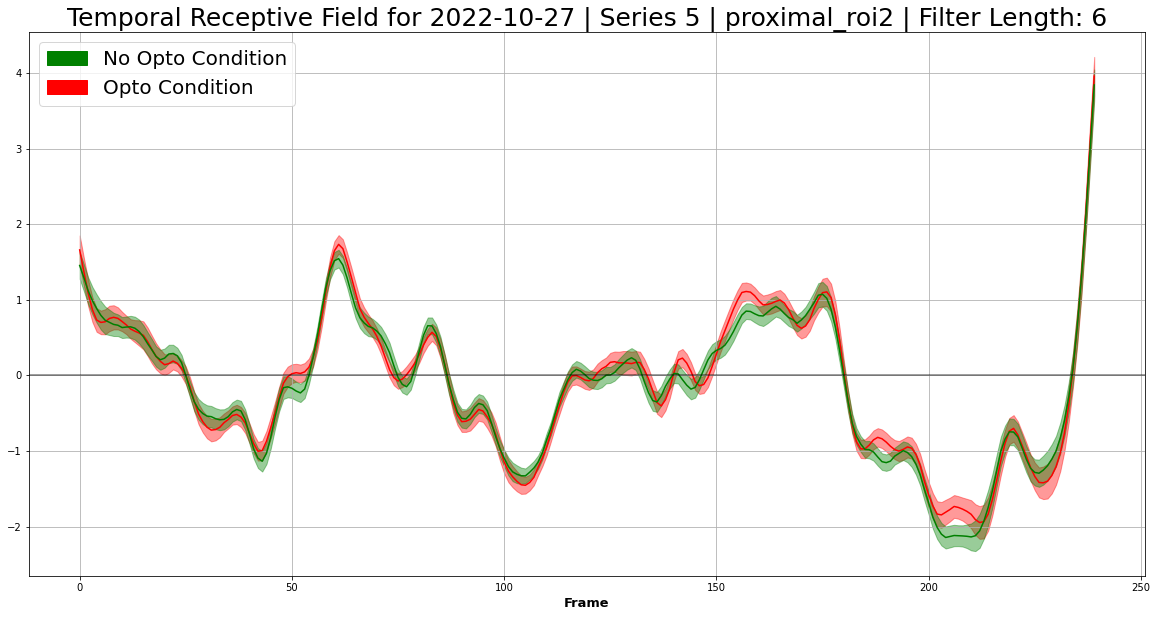

In [409]:
# SEM Plot!
fh, ax = plt.subplots(1,1, figsize=(20,10))
time = np.arange(0,roi_trfs.shape[1])

print(test)
ax.plot(time, np.squeeze(yopto_mean_trf), color='r')
ax.fill_between(time, yopto_sem_plus, yopto_sem_minus, color='r', alpha=.4)
ax.plot(time, np.squeeze(nopto_mean_trf), color='g')
ax.fill_between(time, nopto_sem_plus, nopto_sem_minus, color='g', alpha=.4)
ax.axhline(y=0, color='k', alpha=0.5)
red_patch = mpatches.Patch(color='red', label='Opto Condition')
green_patch = mpatches.Patch(color='green', label='No Opto Condition')

ax.legend(handles=[green_patch, red_patch], fontsize=20)
ax.set_title(f'Temporal Receptive Field for {experiment_file_name} | Series {series_number} | {roi_set_name} | Filter Length: {filter_length}', fontsize=25)
ax.set_xlabel('Frame', fontweight ='bold', fontsize=13)
ax.grid(True)
fh.savefig(save_directory+'TemporalReceptiveField.'+str(experiment_file_name)+'.'+str(series_number)+'.'+str(roi_set_name)+'.FilterLength'+str(filter_length)+'.pdf', dpi=300)